## Importing and Downloading the necessary libraries and setting up the environment

In [1]:
import subprocess
import sys

In [2]:
def install_packages():
    packages = [
        'pandas',
        'numpy',
        'matplotlib',
        'seaborn',
        'scikit-learn',
        'nltk',
        'wordcloud',
        'textblob',
        'transformers',
        'torch',
        'datasets'
    ]
    
    for package in packages:
        try:
            __import__(package)
        except ImportError:
            print(f"Installing {package}...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])

install_packages()

Installing scikit-learn...


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from wordcloud import WordCloud
import re

In [46]:
from sklearn.svm import LinearSVC

In [4]:
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('vader_lexicon', quiet=True)

True

In [5]:
from nltk.tokenize import TreebankWordTokenizer

## Loading the Dataset 

In [6]:
import os
import json
#download the Kaggle API token and make sure it is saved as kaggle.json in the current directory
if not os.path.exists("kaggle.json"):
    print("Please download your Kaggle API token from https://www.kaggle.com/account and save it as kaggle.json in the current directory.")
    sys.exit(1)
with open("kaggle.json", "r") as file:
    kaggle_token = json.load(file)

os.environ['KAGGLE_USERNAME'] = kaggle_token['username']
os.environ['KAGGLE_KEY'] = kaggle_token['key']

In [7]:
!pip install -q kaggle
!kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset

Dataset URL: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset
License(s): CC-BY-NC-SA-4.0
fake-and-real-news-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [8]:
import zipfile

with zipfile.ZipFile("fake-and-real-news-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("news_data")

In [9]:
import pandas as pd

fake_df = pd.read_csv("news_data/Fake.csv")
real_df = pd.read_csv("news_data/True.csv")

print("Fake News Shape:", fake_df.shape)
print("Real News Shape:", real_df.shape)

Fake News Shape: (23481, 4)
Real News Shape: (21417, 4)


## Preview of the dataset along with some basic data analysis and visualization to understand the dataset

Dataset loaded successfully!
Dataset shape: (44898, 5)
Columns: ['title', 'text', 'subject', 'date', 'label']

First few rows:


,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0



Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB

Label distribution:
label
0    23481
1    21417
Name: count, dtype: int64
Fake news: 23481
Real news: 21417


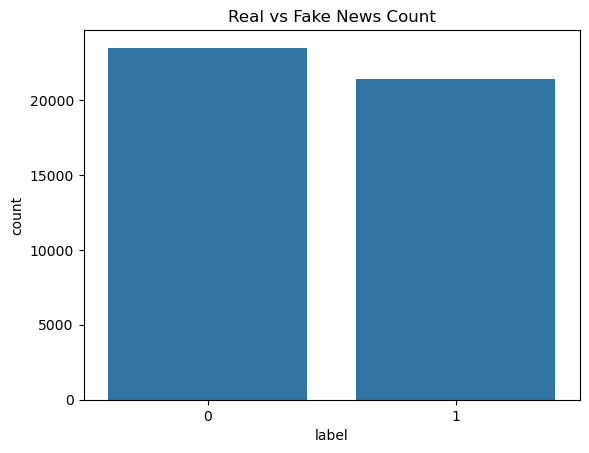

In [10]:
fake_df["label"] = 0
real_df["label"] = 1

df = pd.concat([fake_df, real_df], axis=0).reset_index(drop=True)

if df is not None:
    print("Dataset loaded successfully!")
    print(f"Dataset shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    print("\nFirst few rows:")
    display(df.head())
    
    print("\nDataset info:")
    df.info()
    
    print("\nLabel distribution:")
    print(df['label'].value_counts())
    print(f"Fake news: {(df['label'] == 0).sum()}")
    print(f"Real news: {(df['label'] == 1).sum()}")
    sns.countplot(data=df, x='label')
    plt.title("Real vs Fake News Count")
    plt.show()

<Axes: xlabel='subject'>

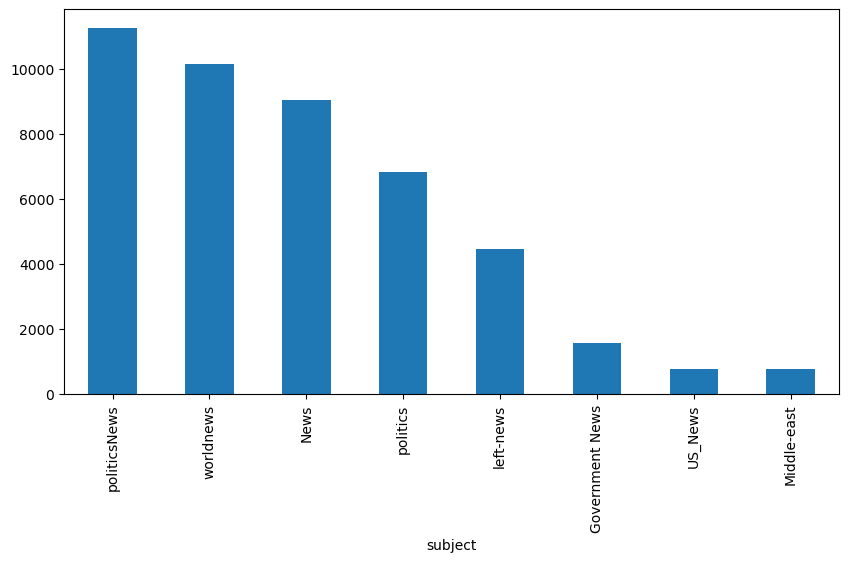

In [11]:

df["subject"].value_counts().plot(kind='bar', figsize=(10, 5))

In [12]:
def create_domain_mapping(df):
    #Creating domain categories based on subject
    domain_mapping = {
        'politicsNews': 'Politics',
        'Government News': 'Politics',
        'politics': 'Politics',
        'worldnews': 'News',
        'News': 'News',
        'left-news': 'Politics',
        'US_News': 'News',
        'Middle-east': 'News',
    }
    
    df['domain'] = df['subject'].map(domain_mapping)
    df['domain'] = df['domain'].fillna('Other')
    
    return df

In [13]:
df = create_domain_mapping(df)

=== EXPLORATORY DATA ANALYSIS ===

Domain distribution:
domain
Politics    24142
News        20756
Name: count, dtype: int64

Label distribution by domain:


label,0,1
domain,,
News,51.12,48.88
Politics,53.31,46.69


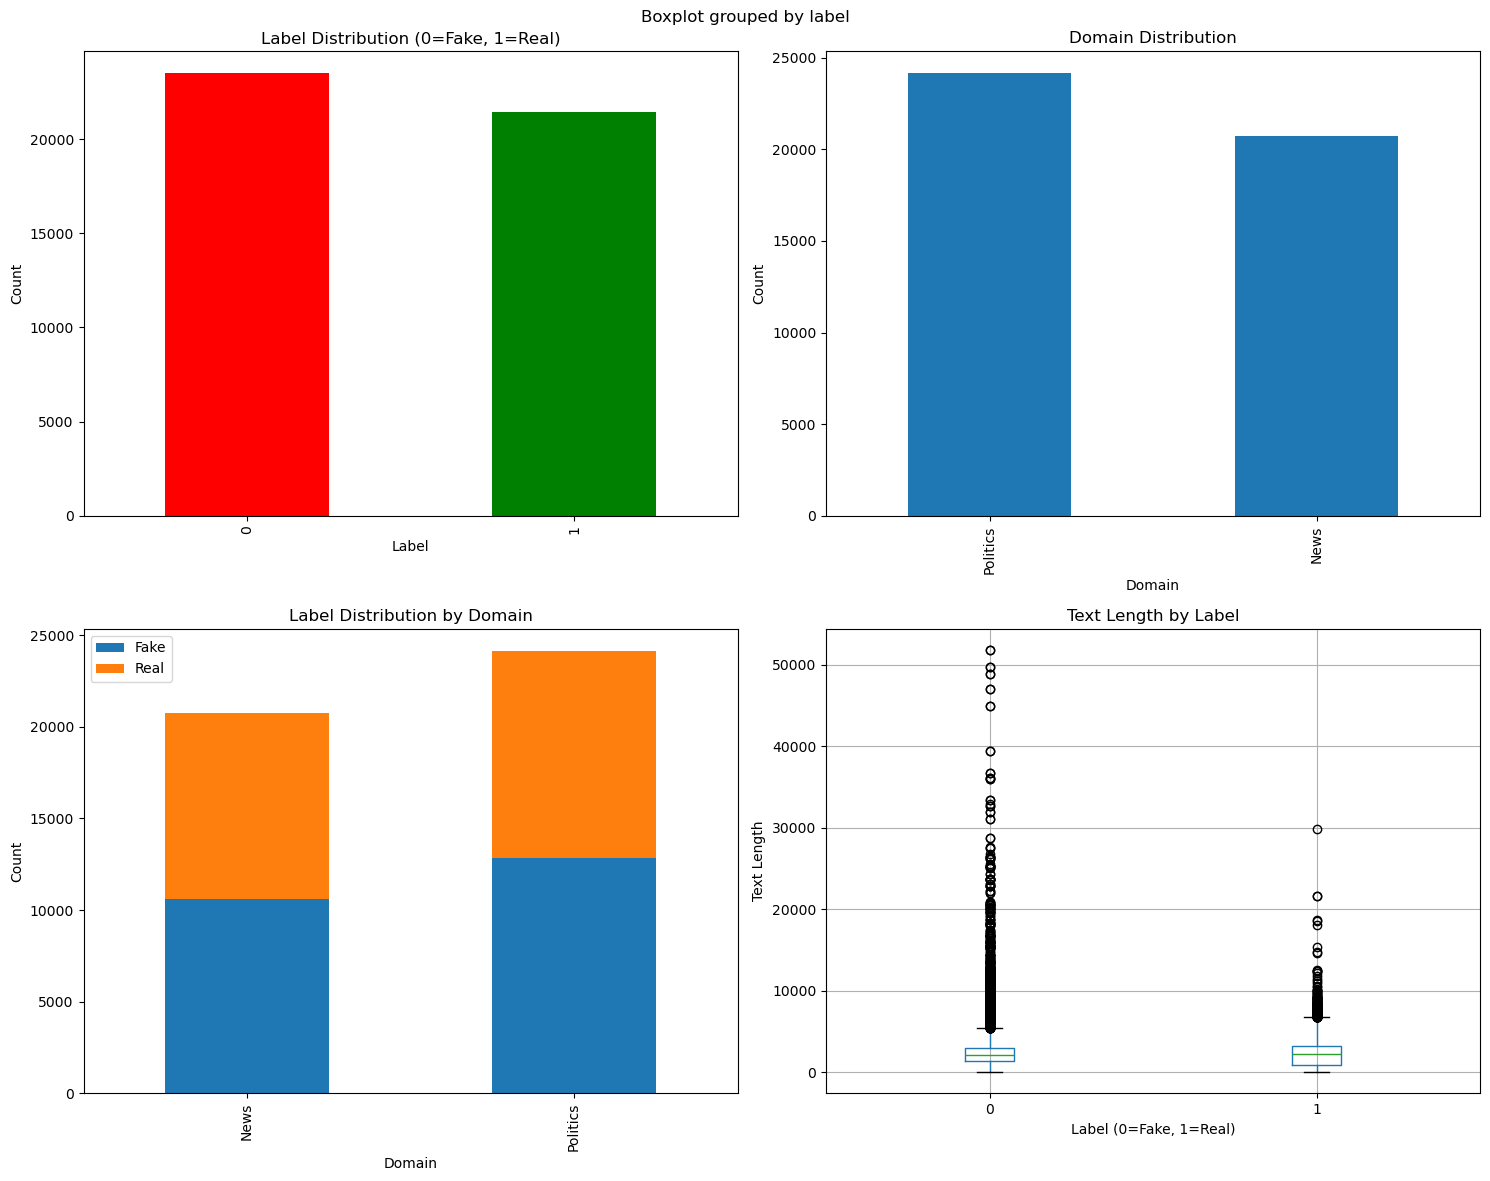


Average text length by label:
label
0    2547.396235
1    2383.278517
Name: text_length, dtype: float64

Average text length by domain:
domain
News        2581.055695
Politics    2372.864510
Name: text_length, dtype: float64


In [14]:
print("=== EXPLORATORY DATA ANALYSIS ===")
print("\nDomain distribution:")
print(df['domain'].value_counts())
    
print("\nLabel distribution by domain:")
domain_label_dist = pd.crosstab(df['domain'], df['label'], normalize='index') * 100
display(domain_label_dist.round(2))
    
# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Label distribution
df['label'].value_counts().plot(kind='bar', ax=axes[0,0], color=['red', 'green'])
axes[0,0].set_title('Label Distribution (0=Fake, 1=Real)')
axes[0,0].set_xlabel('Label')
axes[0,0].set_ylabel('Count')
    
    # Domain distribution
df['domain'].value_counts().plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Domain Distribution')
axes[0,1].set_xlabel('Domain')
axes[0,1].set_ylabel('Count')
    
    # Label by domain
pd.crosstab(df['domain'], df['label']).plot(kind='bar', ax=axes[1,0], stacked=True)
axes[1,0].set_title('Label Distribution by Domain')
axes[1,0].set_xlabel('Domain')
axes[1,0].set_ylabel('Count')
axes[1,0].legend(['Fake', 'Real'])
    
    # Text length analysis
df['text_length'] = df['text'].str.len()
df.boxplot(column='text_length', by='label', ax=axes[1,1])
axes[1,1].set_title('Text Length by Label')
axes[1,1].set_xlabel('Label (0=Fake, 1=Real)')
axes[1,1].set_ylabel('Text Length')
    
plt.tight_layout()
plt.show()
    
    # Text analysis
print(f"\nAverage text length by label:")
print(df.groupby('label')['text_length'].mean())
    
print(f"\nAverage text length by domain:")
print(df.groupby('domain')['text_length'].mean())


## Text Preprocessing Steps
1)Cleaning the text - lowercase, removing urls , email address and white space
2)tokenize it and remove stopwords and lemmatize it 

In [ ]:
class TextPreprocessor:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        self.boilerplate_tokens = [
            'reuters', 'washington', 'associated press', 'video', 'image', 
            'click', 'share', 'subscribe', 'source', 'report', 'wire', 'photo'
        ]
    
    def clean_text(self, text):
        """Clean and preprocess text"""
        if pd.isna(text):
            return ""
        
        # Convert to lowercase
        text = text.lower()
        
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        
        # Remove email addresses
        text = re.sub(r'\S+@\S+', '', text)
        
        # Remove special characters and digits
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        
        # Remove extra whitespace
        text = ' '.join(text.split())
        
        return text
    
    def preprocess_text(self, text):
        # Clean text
        text = self.clean_text(text)
        
        # Tokenize
        
        tokenizer = TreebankWordTokenizer()
        tokens = tokenizer.tokenize(text)
        
        # Remove stopwords and lemmatize
        tokens = [self.lemmatizer.lemmatize(token) for token in tokens if token not in self.stop_words and len(token) > 2]
        
        return ' '.join(tokens)
    
    def extract_features(self, df):
        """Extract additional features from text"""
        features = pd.DataFrame()
        
        # Basic features
        features['title_length'] = df['title'].str.len()
        features['text_length'] = df['text'].str.len()
        features['title_word_count'] = df['title'].str.split().str.len()
        features['text_word_count'] = df['text'].str.split().str.len()
        
        # Sentiment analysis
        features['title_sentiment'] = df['title'].apply(lambda x: TextBlob(str(x)).sentiment.polarity if pd.notna(x) else 0)
        features['text_sentiment'] = df['text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity if pd.notna(x) else 0)
        
        # Readability features
        features['avg_word_length'] = df['text'].apply(lambda x: np.mean([len(word) for word in str(x).split()]) if pd.notna(x) and len(str(x).split()) > 0 else 0)
        features['exclamation_count'] = df['text'].str.count('!')
        features['question_count'] = df['text'].str.count('\?')
        features['caps_ratio'] = df['text'].apply(lambda x: sum(1 for c in str(x) if c.isupper()) / len(str(x)) if pd.notna(x) and len(str(x)) > 0 else 0)
        
        return features


In [16]:
if df is not None:
    # Initialize preprocessor
    preprocessor = TextPreprocessor()
    
    # Combine title and text
    df['combined_text'] = df['title'].fillna('') + ' ' + df['text'].fillna('')
    
    

In [17]:
# Preprocess text
print("Preprocessing text...")
df['processed_text'] = df['combined_text'].apply(preprocessor.preprocess_text)
    
    

Preprocessing text...


In [19]:
# Extract additional features
print("Extracting features...")
additional_features = preprocessor.extract_features(df)
    
    # Combine with main dataframe
df = pd.concat([df, additional_features], axis=1)
print("Preprocessing complete!")
print(f"Final dataset shape: {df.shape}")


Extracting features...
Preprocessing complete!
Final dataset shape: (44898, 19)


In [21]:
def evaluate_model(model, X_test, y_test, domain_test=None):
    """Comprehensive model evaluation"""
    # Predictions
    y_pred = model.predict(X_test)
    
    # Overall metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred)
    }
    
    print("=== OVERALL PERFORMANCE ===")
    for metric, value in metrics.items():
        print(f"{metric.capitalize()}: {value:.4f}")
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Domain-specific performance
    if domain_test is not None:
        print("\n=== DOMAIN-SPECIFIC PERFORMANCE ===")
        domains = domain_test.unique()
        domain_metrics = []
        
        for domain in domains:
            domain_mask = domain_test == domain
            if domain_mask.sum() > 0:
                domain_y_test = y_test[domain_mask]
                domain_y_pred = y_pred[domain_mask]
                
                domain_metric = {
                    'domain': domain,
                    'accuracy': accuracy_score(domain_y_test, domain_y_pred),
                    'precision': precision_score(domain_y_test, domain_y_pred, zero_division=0),
                    'recall': recall_score(domain_y_test, domain_y_pred, zero_division=0),
                    'f1': f1_score(domain_y_test, domain_y_pred, zero_division=0),
                    'support': len(domain_y_test)
                }
                domain_metrics.append(domain_metric)
        
        domain_df = pd.DataFrame(domain_metrics)
        display(domain_df.round(4))
        
        # Visualize domain performance
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        
        domain_df.set_index('domain')[['accuracy', 'precision', 'recall', 'f1']].plot(kind='bar', ax=axes[0])
        axes[0].set_title('Performance Metrics by Domain')
        axes[0].set_ylabel('Score')
        axes[0].legend()
        axes[0].tick_params(axis='x', rotation=45)
        
        domain_df.plot(x='domain', y='support', kind='bar', ax=axes[1])
        axes[1].set_title('Test Set Size by Domain')
        axes[1].set_ylabel('Number of Samples')
        axes[1].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
    
    return metrics

In [ ]:
def get_feature_importance(model, feature_names, top_n=20):
    """Extract and visualize feature importance"""
    if hasattr(model, 'coef_'):
        # For linear models like Logistic Regression
        if hasattr(model, 'named_steps'):
            # If it's a pipeline
            if 'classifier' in model.named_steps:
                coefficients = model.named_steps['classifier'].coef_[0]
            else:
                coefficients = model.coef_[0]
        else:
            coefficients = model.coef_[0]
        
        # Get feature importance (absolute values)
        importance = np.abs(coefficients)
        
    elif hasattr(model, 'feature_importances_'):
        # For tree-based models
        if hasattr(model, 'named_steps'):
            if 'classifier' in model.named_steps:
                importance = model.named_steps['classifier'].feature_importances_
            else:
                importance = model.feature_importances_
        else:
            importance = model.feature_importances_
    else:
        print("Cannot extract feature importance for this model type")
        return
    
    # Create feature importance dataframe
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False)
    
    # Plot top features
    plt.figure(figsize=(10, 8))
    top_features = feature_importance_df.head(top_n)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top {top_n} Most Important Features')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    return feature_importance_df

=== STEP 1: BASELINE MODEL ===
=== CROSS-VALIDATION RESULTS ===

--- Logistic Regression Cross-Validation ---
CV F1 Score: 0.9861 (+/- 0.0029)
Individual fold scores: [0.98491004 0.98667053 0.98377752 0.98767937 0.98722045]

--- Random Forest Cross-Validation ---
CV F1 Score: 0.9877 (+/- 0.0040)
Individual fold scores: [0.98893096 0.99038462 0.98544396 0.98533895 0.98847893]

--- SVM Cross-Validation ---
CV F1 Score: 0.9847 (+/- 0.0026)
Individual fold scores: [0.98362081 0.98540251 0.98276611 0.9863847  0.98520453]

=== HOLD-OUT TEST SET RESULTS ===

--- Logistic Regression ---
=== OVERALL PERFORMANCE ===
Accuracy: 0.9862
Precision: 0.9771
Recall: 0.9944
F1: 0.9857


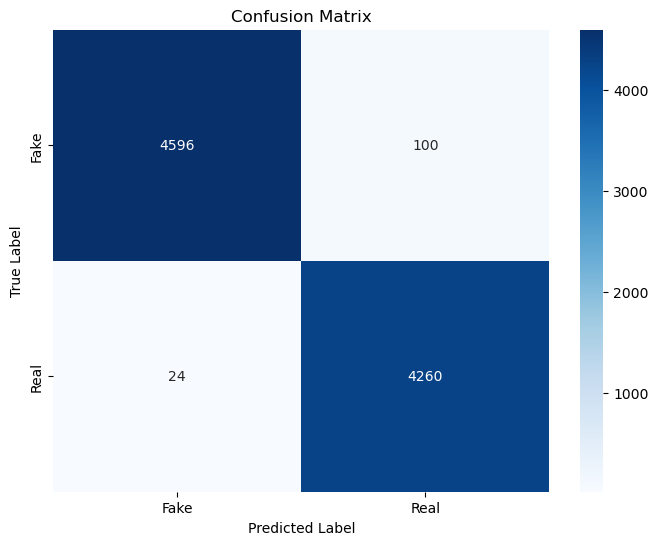


=== DOMAIN-SPECIFIC PERFORMANCE ===


,domain,accuracy,precision,recall,f1,support
0,Politics,0.9843,0.9749,0.9913,0.9831,4772
1,News,0.9884,0.9793,0.9976,0.9884,4208


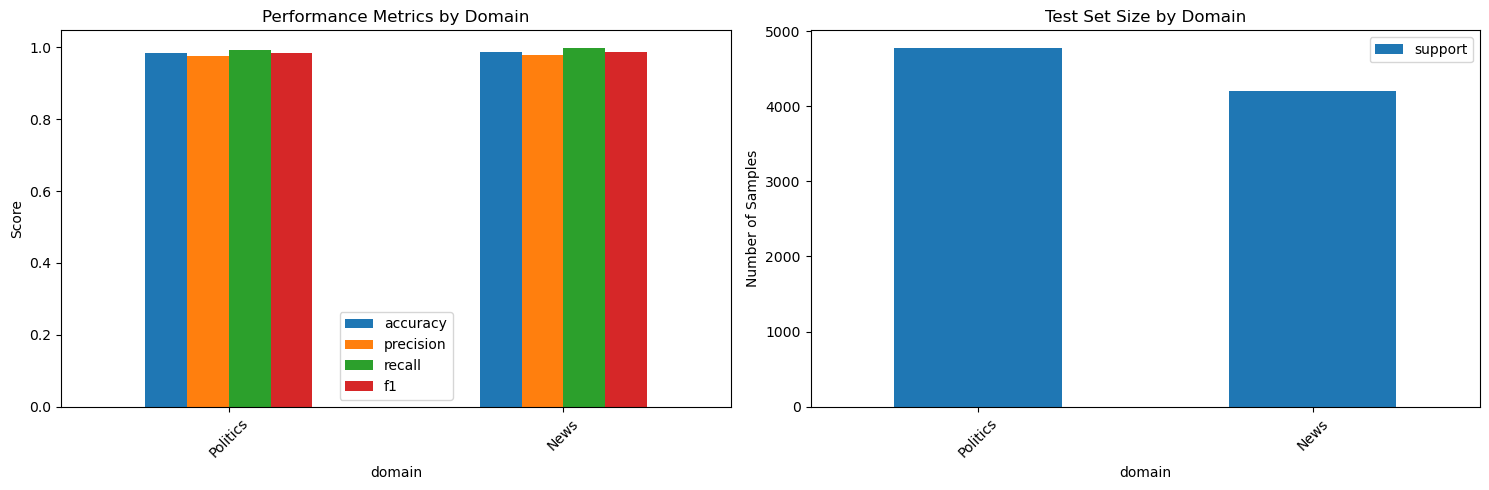

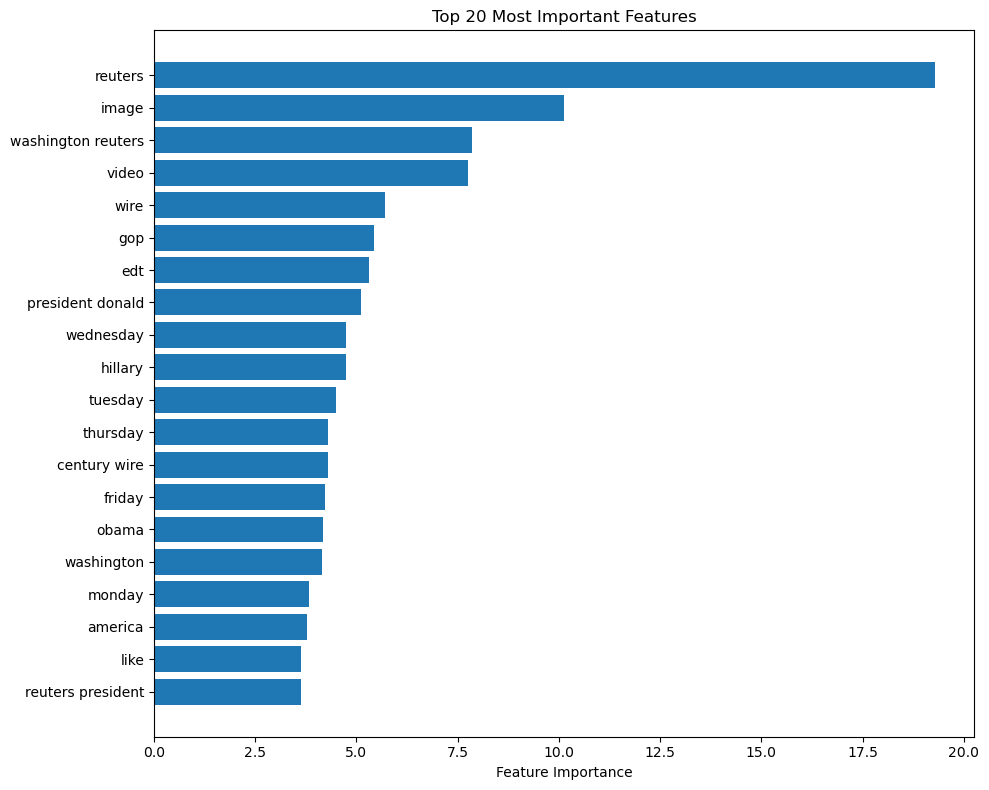


Top 10 most important features for Logistic Regression:


,feature,importance
3730,reuters,19.292775
2092,image,10.135377
4862,washington reuters,7.865210
4793,video,7.748606
4926,wire,5.695130
1835,gop,5.427765
1352,edt,5.321482
3316,president donald,5.114663
4881,wednesday,4.750511
1990,hillary,4.744189


⚠️  WARNING: Found suspicious features that might indicate data leakage:


,feature,importance
3730,reuters,19.292775
4862,washington reuters,7.865210
3733,reuters president,3.632497
4543,told reuters,2.574914
4985,york reuters,2.231431



--- Random Forest ---
=== OVERALL PERFORMANCE ===
Accuracy: 0.9900
Precision: 0.9859
Recall: 0.9932
F1: 0.9895


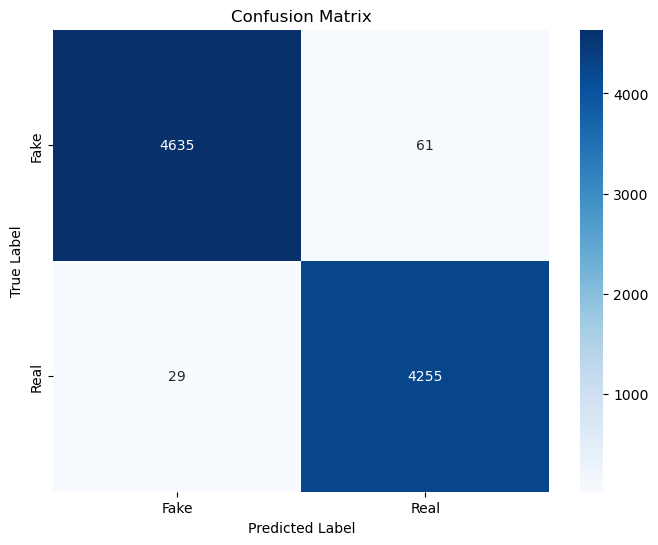


=== DOMAIN-SPECIFIC PERFORMANCE ===


,domain,accuracy,precision,recall,f1,support
0,Politics,0.9860,0.9771,0.9927,0.9849,4772
1,News,0.9945,0.9952,0.9938,0.9945,4208


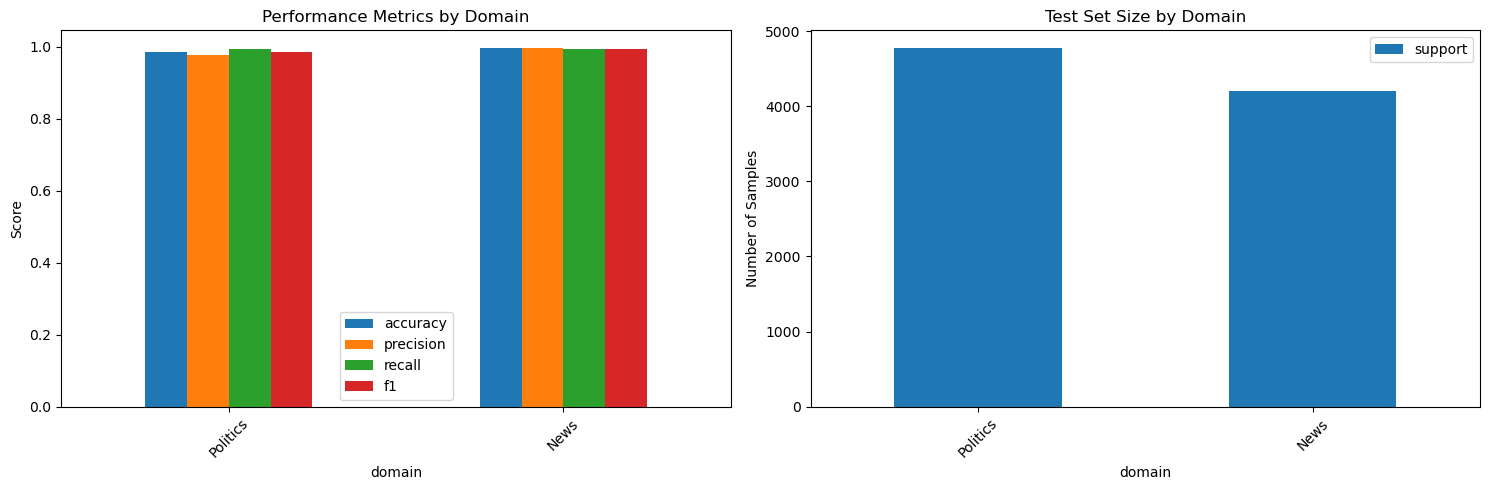

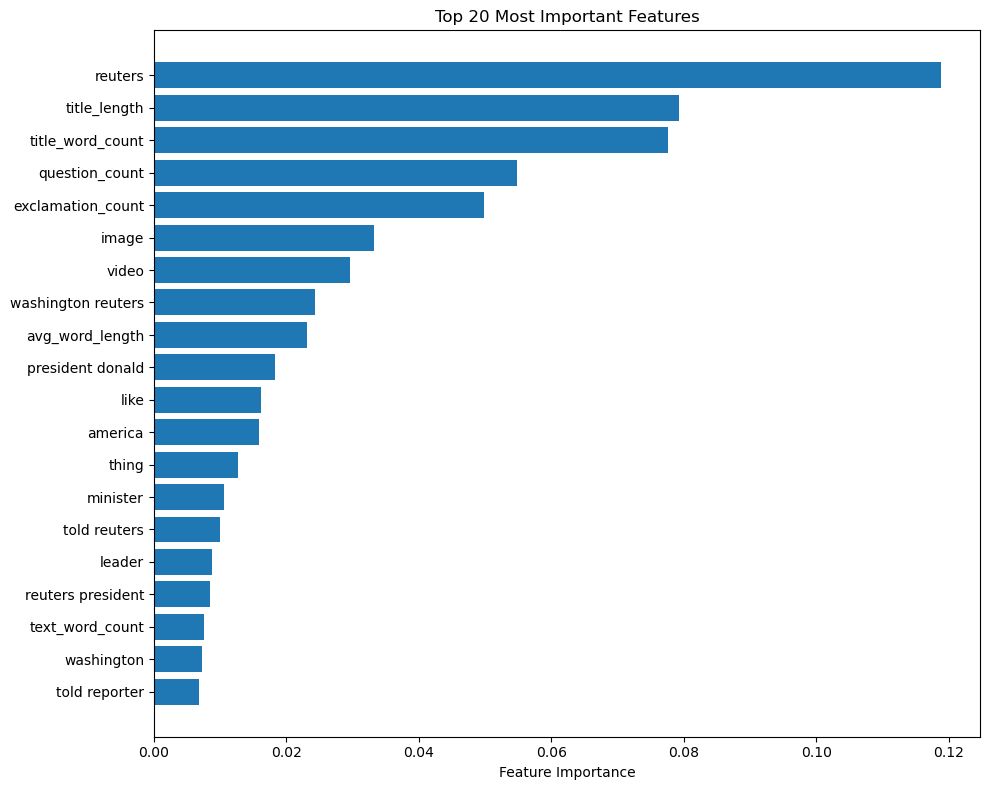


Top 10 most important features for Random Forest:


,feature,importance
3730,reuters,0.118755
5000,title_length,0.079317
5003,title_word_count,0.077548
5009,question_count,0.054859
5008,exclamation_count,0.049895
2092,image,0.033169
4793,video,0.029620
4862,washington reuters,0.024327
5007,avg_word_length,0.023126
3316,president donald,0.018357


⚠️  WARNING: Found suspicious features that might indicate data leakage:


,feature,importance
3730,reuters,0.118755
4862,washington reuters,0.024327
4543,told reuters,0.009999
3733,reuters president,0.008540
4985,york reuters,0.001145



--- SVM ---
=== OVERALL PERFORMANCE ===
Accuracy: 0.9851
Precision: 0.9748
Recall: 0.9944
F1: 0.9845


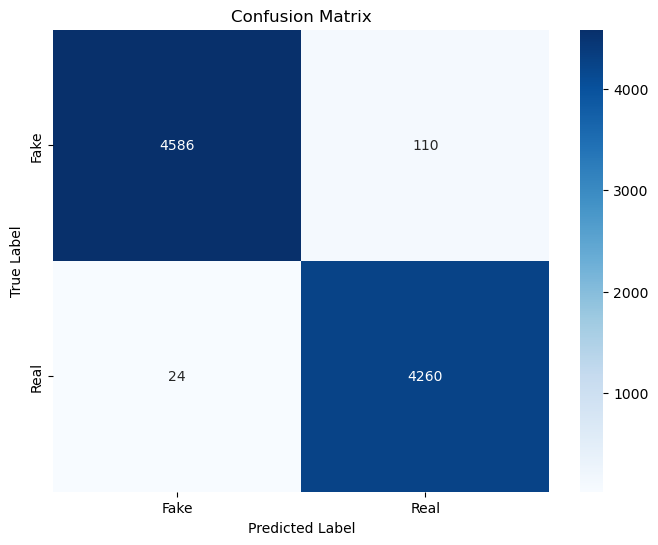


=== DOMAIN-SPECIFIC PERFORMANCE ===


,domain,accuracy,precision,recall,f1,support
0,Politics,0.9832,0.9727,0.9913,0.9820,4772
1,News,0.9872,0.9770,0.9976,0.9872,4208


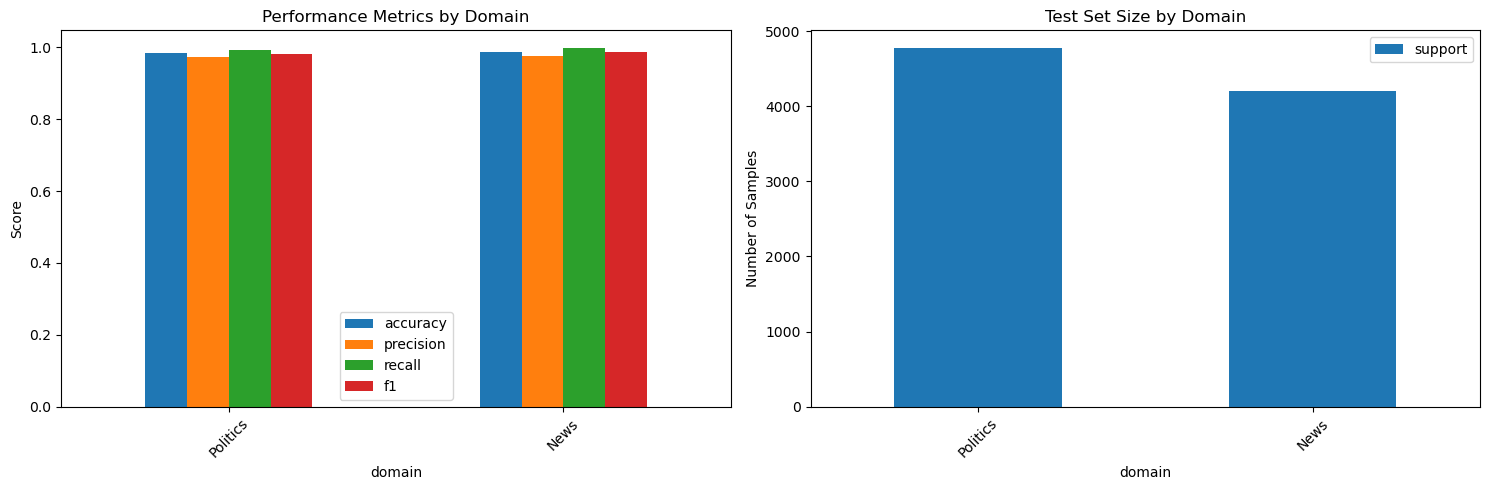


=== BASELINE MODEL COMPARISON ===


,accuracy,precision,recall,f1,cv_f1_mean,cv_f1_std
Logistic Regression,0.9862,0.9771,0.9944,0.9857,0.9861,0.0015
Random Forest,0.9900,0.9859,0.9932,0.9895,0.9877,0.0020
SVM,0.9851,0.9748,0.9944,0.9845,0.9847,0.0013


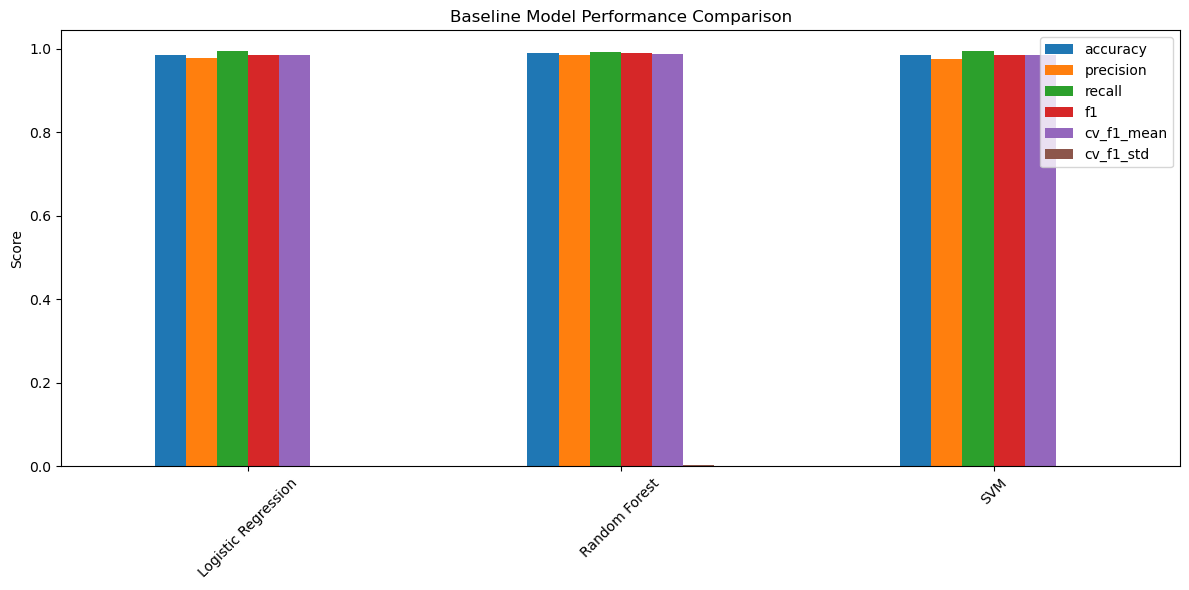

In [ ]:


if df is not None:
    print("=== STEP 1: BASELINE MODEL ===")
    
    # Prepare features
    X_text = df['processed_text']
    X_features = df[['title_length', 'text_length', 'title_word_count', 'text_word_count', 
                     'title_sentiment', 'text_sentiment', 'avg_word_length', 
                     'exclamation_count', 'question_count', 'caps_ratio']]
    y = df['label']
    domains = df['domain']
    
    # Split data
    X_text_train, X_text_test, X_feat_train, X_feat_test, y_train, y_test, domain_train, domain_test = train_test_split(
        X_text, X_features, y, domains, test_size=0.2, random_state=42, stratify=y
    )
    
    # Create TF-IDF vectorizer with parameters
    tfidf = TfidfVectorizer(
        max_features=5000,  
        ngram_range=(1, 2), 
        min_df=5,          
        max_df=0.5,        
        stop_words='english'  
    )
    X_text_train_tfidf = tfidf.fit_transform(X_text_train)
    X_text_test_tfidf = tfidf.transform(X_text_test)
    
    # Combine text and numerical features
    from scipy.sparse import hstack
    from sklearn.preprocessing import StandardScaler
    
    scaler = StandardScaler()
    X_feat_train_scaled = scaler.fit_transform(X_feat_train)
    X_feat_test_scaled = scaler.transform(X_feat_test)
    
    X_train_combined = hstack([X_text_train_tfidf, X_feat_train_scaled])
    X_test_combined = hstack([X_text_test_tfidf, X_feat_test_scaled])
    
    # Train baseline models with cross-validation for more robust evaluation
    models = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, C=1.0),
        'Random Forest': RandomForestClassifier(n_estimators=50, random_state=42, max_depth=10),  
        'SVM': SVC(kernel='linear', random_state=42, C=0.1)  
    }
    
    baseline_results = {}
    
    # First, let's do cross-validation to get more realistic estimates
    print("=== CROSS-VALIDATION RESULTS ===")
    cv_results = {}
    
    for name, model in models.items():
        print(f"\n--- {name} Cross-Validation ---")
        
        if name == 'Random Forest':
            # Use combined features for RF and SVM
            cv_scores = cross_val_score(model, X_train_combined, y_train, cv=5, scoring='f1')
        else:
            cv_scores = cross_val_score(model, X_train_combined, y_train, cv=5, scoring='f1')
        
        cv_results[name] = {
            'mean_f1': cv_scores.mean(),
            'std_f1': cv_scores.std(),
            'scores': cv_scores
        }
        
        print(f"CV F1 Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        print(f"Individual fold scores: {cv_scores}")
    
    print("\n=== HOLD-OUT TEST SET RESULTS ===")
    
    for name, model in models.items():
        print(f"\n--- {name} ---")
        
        # Train model
        model.fit(X_train_combined, y_train)
        metrics = evaluate_model(model, X_test_combined, y_test, domain_test)
        
        baseline_results[name] = metrics
        
        # Add cross-validation info
        baseline_results[name]['cv_f1_mean'] = cv_results[name]['mean_f1']
        baseline_results[name]['cv_f1_std'] = cv_results[name]['std_f1']
        
        # Check if test performance is suspiciously higher than CV
        test_cv_diff = metrics['f1'] - cv_results[name]['mean_f1']
        if test_cv_diff > 0.05:  
            print(f"⚠️  WARNING: Test F1 ({metrics['f1']:.4f}) much higher than CV F1 ({cv_results[name]['mean_f1']:.4f})")
            print("This suggests potential overfitting or data leakage!")
        
        # Feature importance analysis for interpretable models
        if name in ['Logistic Regression', 'Random Forest']:
            feature_names = list(tfidf.get_feature_names_out()) + list(X_feat_train.columns)
            importance_df = get_feature_importance(model, feature_names)
            print(f"\nTop 10 most important features for {name}:")
            display(importance_df.head(10))
            
            # Check for suspicious features (publisher names, etc.)
            suspicious_features = importance_df[importance_df['feature'].str.contains(
                'reuters|cnn|fox|breitbart|huffpost|washingtonpost|nytimes', case=False, na=False
            )]
            if len(suspicious_features) > 0:
                print("⚠️  WARNING: Found suspicious features that might indicate data leakage:")
                display(suspicious_features.head())
    
    # Compare baseline models
    baseline_comparison = pd.DataFrame(baseline_results).T
    print("\n=== BASELINE MODEL COMPARISON ===")
    display(baseline_comparison.round(4))
    
    # Visualize comparison
    baseline_comparison.plot(kind='bar', figsize=(12, 6))
    plt.title('Baseline Model Performance Comparison')
    plt.ylabel('Score')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## We can clearly see that model is overfitting and it maybe due to Source Names from the text or adding too many features 

### Lets try to address the issue from above
1) removing source names and other boilerplate tokens seen in the results
2) Re-run TF-IDF without title and metadata
3) Reducing the features given by tfidf vectorizer

In [31]:
class TextPreprocessor:
    def __init__(self):
        self.tokenizer = TreebankWordTokenizer()
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()
        self.boilerplate_tokens = [
            'reuters', 'washington', 'associated press', 'video', 'image', 
            'click', 'share', 'subscribe', 'source', 'report', 'wire', 'photo'
        ]

    def clean_text(self, text):
        if pd.isna(text):
            return ""
        text = text.lower()
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)
        text = re.sub(r'\S+@\S+', '', text)
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        text = ' '.join(text.split())
        for token in self.boilerplate_tokens:
            text = re.sub(r'\b' + re.escape(token) + r'\b', '', text)
        return text

    def preprocess_text(self, text):
        text = self.clean_text(text)
        tokens = self.tokenizer.tokenize(text)
        tokens = [self.lemmatizer.lemmatize(token) for token in tokens if token not in self.stop_words and len(token) > 2]
        return ' '.join(tokens)

    def extract_features(self, df):
        features = pd.DataFrame()
        features['title_length'] = df['title'].str.len()
        features['text_length'] = df['text'].str.len()
        features['title_word_count'] = df['title'].str.split().str.len()
        features['text_word_count'] = df['text'].str.split().str.len()
        features['title_sentiment'] = df['title'].apply(lambda x: TextBlob(str(x)).sentiment.polarity if pd.notna(x) else 0)
        features['text_sentiment'] = df['text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity if pd.notna(x) else 0)
        features['avg_word_length'] = df['text'].apply(
    lambda x: np.mean([len(word) for word in str(x).split()]) if pd.notna(x) and len(str(x).split()) > 0 else 0
)
        features['exclamation_count'] = df['text'].str.count('!')
        features['question_count'] = df['text'].str.count('\?')
        features['caps_ratio'] = df['text'].apply(lambda x: sum(1 for c in str(x) if c.isupper()) / len(str(x)) if pd.notna(x) else 0)
        return features

In [61]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
    plt.title('Confusion Matrix')
    plt.show()
    return {
        'accuracy': float(accuracy_score(y_test, y_pred)),
        'precision': float(precision_score(y_test, y_pred)),
        'recall': float(recall_score(y_test, y_pred)),
        'f1': float(f1_score(y_test, y_pred))
    }


# Preprocessing
preprocessor = TextPreprocessor()
df['text_only'] = df['text'].apply(preprocessor.preprocess_text)
df['processed_text'] = df['text_only']
df_features = preprocessor.extract_features(df)



In [62]:
# === FEATURE ENGINEERING ===
X_text = df['processed_text']
X_numerical = df_features
y = df['label']

X_text_train, X_text_test, X_feat_train, X_feat_test, y_train, y_test = train_test_split(
    X_text, X_numerical, y, test_size=0.2, stratify=y, random_state=42
)

# TF-IDF
vectorizer = TfidfVectorizer(
    max_features=1000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.5,
    stop_words='english',
    strip_accents='unicode',
    token_pattern=r'\b[a-zA-Z]{3,}\b'
)
X_text_train_tfidf = vectorizer.fit_transform(X_text_train)
X_text_test_tfidf = vectorizer.transform(X_text_test)

# Combine features
scaler = StandardScaler()
X_feat_train_scaled = scaler.fit_transform(X_feat_train)
X_feat_test_scaled = scaler.transform(X_feat_test)
X_train = hstack([X_text_train_tfidf, X_feat_train_scaled])
X_test = hstack([X_text_test_tfidf, X_feat_test_scaled])

print("NaNs in X_feat_train:\n", X_feat_train.isnull().sum())
print("NaNs in X_feat_test:\n", X_feat_test.isnull().sum())



NaNs in X_feat_train:
 title_length         0
text_length          0
title_word_count     0
text_word_count      0
title_sentiment      0
text_sentiment       0
avg_word_length      0
exclamation_count    0
question_count       0
caps_ratio           0
dtype: int64
NaNs in X_feat_test:
 title_length         0
text_length          0
title_word_count     0
text_word_count      0
title_sentiment      0
text_sentiment       0
avg_word_length      0
exclamation_count    0
question_count       0
caps_ratio           0
dtype: int64


In [63]:
results = {}
feature_names = list(vectorizer.get_feature_names_out()) + list(X_feat_train.columns)

def plot_top_features(model, feature_names, title, coef_type='coef_'):
    if coef_type == 'coef_':
        if hasattr(model, 'coef_'):
            # Flatten if needed
            if len(model.coef_.shape) > 1:
                coefficients = model.coef_.toarray()[0] if hasattr(model.coef_, 'toarray') else model.coef_[0]
            else:
                coefficients = model.coef_
        else:
            print(f"Model does not support coef_: {title}")
            return
    else:
        coefficients = model
    
    # Convert to DataFrame
    top_features = pd.DataFrame({
        'feature': feature_names,
        'importance': np.abs(coefficients)
    }).sort_values(by='importance', ascending=False).head(15)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(top_features['feature'], top_features['importance'])
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.show()

In [64]:
feature_names

['ability',
 'able',
 'abortion',
 'absolutely',
 'access',
 'according',
 'account',
 'accusation',
 'accused',
 'act',
 'action',
 'activist',
 'activity',
 'actually',
 'added',
 'adding',
 'address',
 'administration',
 'adviser',
 'affair',
 'afghanistan',
 'agency',
 'agenda',
 'agent',
 'ago',
 'agree',
 'agreed',
 'agreement',
 'ahead',
 'aid',
 'aide',
 'air',
 'allegation',
 'alleged',
 'allow',
 'allowed',
 'ally',
 'ambassador',
 'amendment',
 'america',
 'american',
 'american people',
 'announced',
 'answer',
 'apparently',
 'appeal',
 'appeared',
 'appears',
 'approved',
 'april',
 'arab',
 'arabia',
 'area',
 'arm',
 'armed',
 'army',
 'arrest',
 'arrested',
 'article',
 'ask',
 'asked',
 'asking',
 'assault',
 'attack',
 'attempt',
 'attention',
 'attorney',
 'attorney general',
 'august',
 'authority',
 'away',
 'backed',
 'bad',
 'ban',
 'bank',
 'barack',
 'barack obama',
 'base',
 'based',
 'battle',
 'began',
 'begin',
 'behavior',
 'beijing',
 'belief',
 'believe

Accuracy: 0.9778396436525613
Precision: 0.9687858618315355
Recall: 0.9852941176470589
F1 Score: 0.9769702580719825


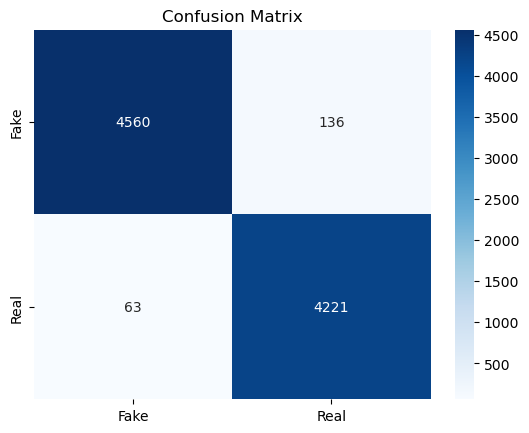

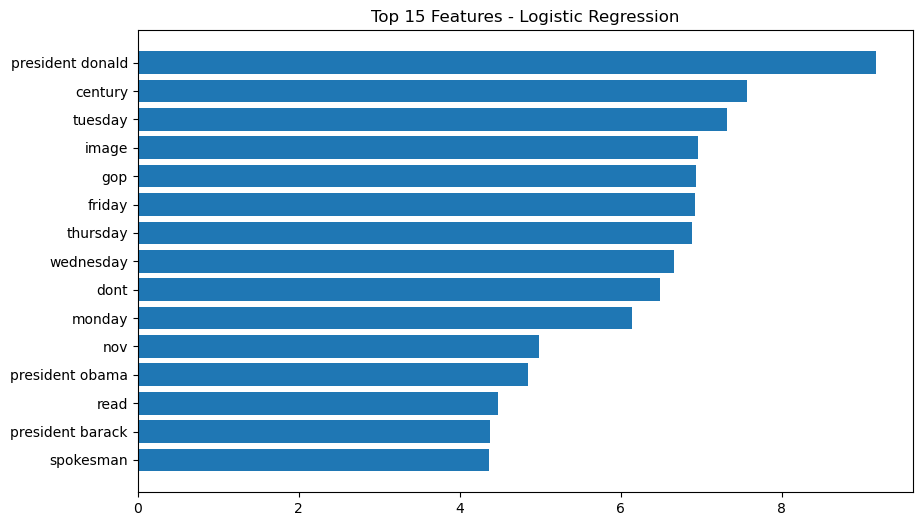

Accuracy: 0.9080178173719377
Precision: 0.9091339327969711
Recall: 0.8968253968253969
F1 Score: 0.9029377203290246


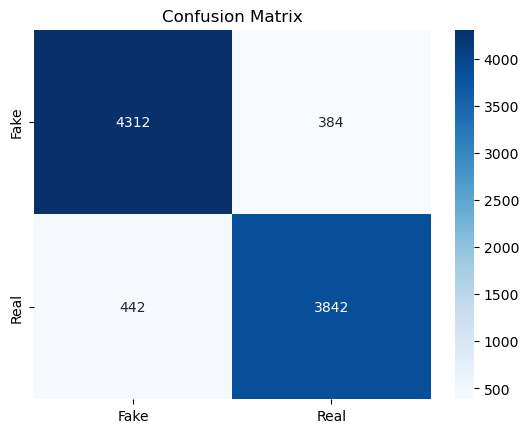

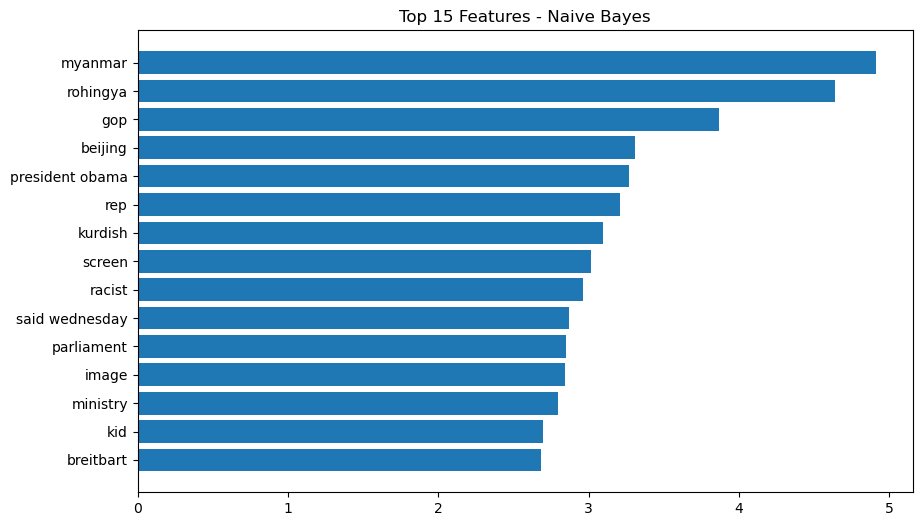

Accuracy: 0.9795100222717149
Precision: 0.9736598890942699
Recall: 0.9836601307189542
F1 Score: 0.9786344635392475


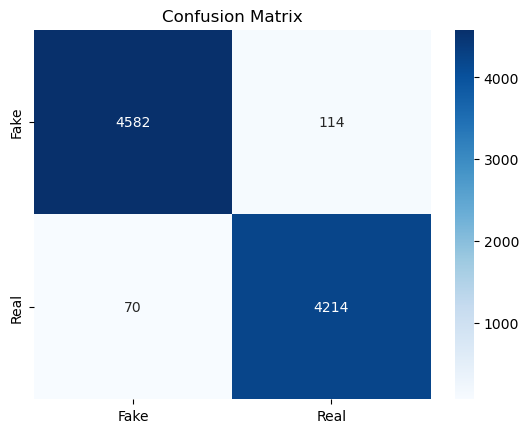

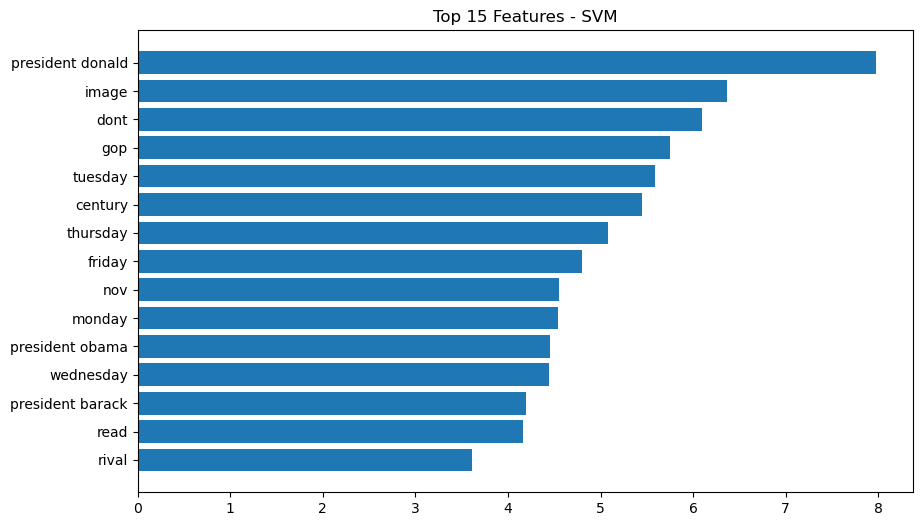

In [ ]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
results['Logistic Regression'] = evaluate_model(lr, X_test, y_test)
plot_top_features(lr, feature_names, "Top 15 Features - Logistic Regression")


nb = MultinomialNB()
nb.fit(X_text_train_tfidf, y_train)
log_prob_diff = nb.feature_log_prob_[1] - nb.feature_log_prob_[0]
results['Naive Bayes'] = evaluate_model(nb, X_text_test_tfidf, y_test)
plot_top_features(log_prob_diff, vectorizer.get_feature_names_out(), "Top 15 Features - Naive Bayes", coef_type='log')


svm = SVC(kernel='linear', C=1.0, random_state=42)
svm.fit(X_train, y_train)
results['SVM'] = evaluate_model(svm, X_test, y_test)
if hasattr(svm, 'coef_'):
    plot_top_features(svm, feature_names, "Top 15 Features - SVM")
else:
    print("SVM model does not support feature importance extraction via coef_ (only for linear kernels)")




=== MODEL COMPARISON ===
                     accuracy  precision  recall      f1
Logistic Regression    0.9778     0.9688  0.9853  0.9770
Naive Bayes            0.9080     0.9091  0.8968  0.9029
SVM                    0.9795     0.9737  0.9837  0.9786


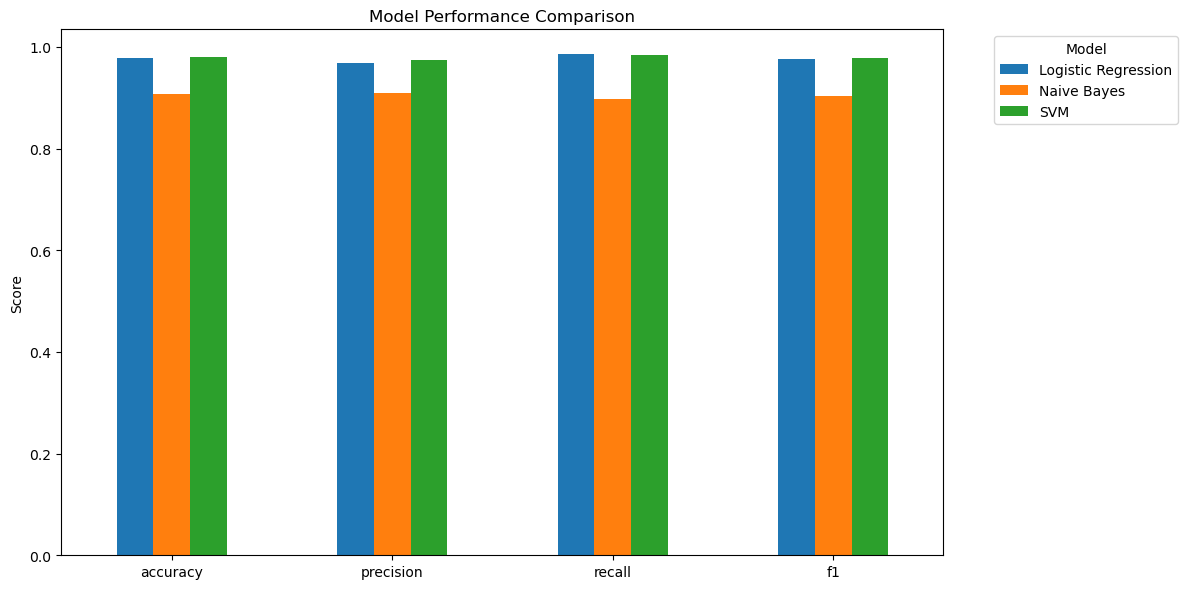

In [ ]:
results_df = pd.DataFrame.from_dict(results, orient='index')
print("\n=== MODEL COMPARISON ===")
print(results_df.round(4))


results_df = results_df.astype(float)

# Plot transposed for clearer grouping
results_df.T.plot(kind='bar', figsize=(12, 6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Step 2
1) we can use ensemble model such as a voting classifier between these three models we have trained
2) we can use transformers/gpt like models for feature engineering using spacy 
3) data augmentation is the process of changing the data so better suit the model some of the processes in nlp are as follows
    Back translation. 
    EDA (Easy Data Augmentation).
    NLP Albumentation.
    NLP Aug.

1) voting classifier ensemble model

Accuracy: 0.978619153674833
Precision: 0.9716459197786999
Recall: 0.9838935574229691
F1 Score: 0.977731384829506


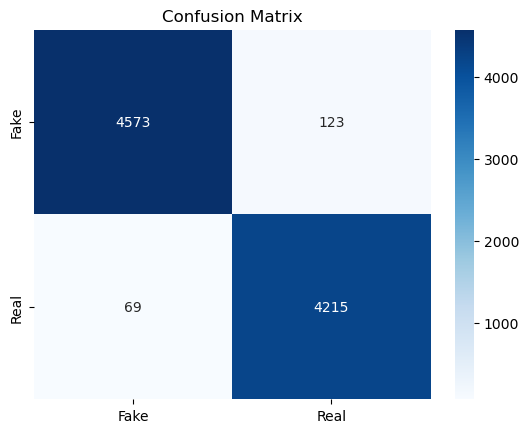

In [69]:
from sklearn.ensemble import VotingClassifier


voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(max_iter=1000, random_state=42)),
        ('svm', SVC(kernel='linear', C=0.5, probability=True, random_state=42))
    ],
    voting='soft'
)

voting_clf.fit(X_train, y_train)
results['Ensemble (Voting)'] = evaluate_model(voting_clf, X_test, y_test)

2) using transformer/gpt / bert like models for feature engineering 

In [70]:
import spacy
nlp = spacy.load("en_core_web_sm")

features['named_entity_count'] = df['text'].apply(
    lambda x: len([ent for ent in nlp(x).ents]) if pd.notna(x) else 0
)

# POS Tag distribution 
features['noun_ratio'] = df['text'].apply(
    lambda x: len([t for t in nlp(x).pos_ if t == 'NOUN']) / (len(x.split()) + 1) if pd.notna(x) else 0
)

ModuleNotFoundError: No module named 'spacy'

3) some data augmentation techniques used in NLP before training 

In [ ]:
import random

def synonym_replacement(text, n=2):
    from nltk.corpus import wordnet
    words = text.split()
    new_words = words.copy()
    random.shuffle(words)
    num_replaced = 0
    for word in words:
        synonyms = wordnet.synsets(word)
        if synonyms:
            synonym = synonyms[0].lemmas()[0].name()
            new_words = [synonym if w == word else w for w in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break
    return ' '.join(new_words)

# Augment only on training data
augmented_texts = X_text_train.sample(frac=0.3, random_state=42).apply(synonym_replacement)
X_text_train_aug = pd.concat([X_text_train, augmented_texts])
y_train_aug = pd.concat([y_train, y_train.loc[augmented_texts.index]])